In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pygimli as pg
from pygimli.viewer.mpl import drawModel1D

In [58]:
# Step 1: Load cows/jackpot data
import csv
import io

rows = []
with open('cowsjackpot.csv', newline='') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
     for row in spamreader:
         rows.append(', '.join(row))


colnames=["N", "a", "n", "ab2", "r", "rhoa", "sigma"] 
dcowsns = pd.read_csv(io.StringIO('\n'.join(rows[2:14])), names=colnames)
dcowses = pd.read_csv(io.StringIO('\n'.join(rows[18:30])), names=colnames)
mcowsns = pd.read_csv(io.StringIO('\n'.join(rows[34:47])), names=colnames)

djackns = pd.read_csv(io.StringIO('\n'.join(rows[51:64])), names=colnames)
mjackns = pd.read_csv(io.StringIO('\n'.join(rows[68:])), names=colnames)

50.13981876
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (13x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.003 s
min data = 3.79347 max data = 25.0699 (13)
min error = 0.03 max error = 0.03 (13)
min response = 13.4774 max response = 13.4774 (13)
calc without reference model
0: rms/rrms(data, response) = 7.42329/101.336%
0: chi^2(data, response, error, log) = 443.88
0: Phi = 5770.45 + 2.32343 * 200 = 5770.45
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 0.99
1: Model: min = 1; max = 27.6916
1: Response: min = 7.56148; max = 25.815
1: rms/rrms(data, Response) = 4.52983/42.4283%
1: chi^2(data, Response, error, log) = 178.235
1: Phi = 2317.06+3.63055*200=2317.06
Iter: 1
calculat

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


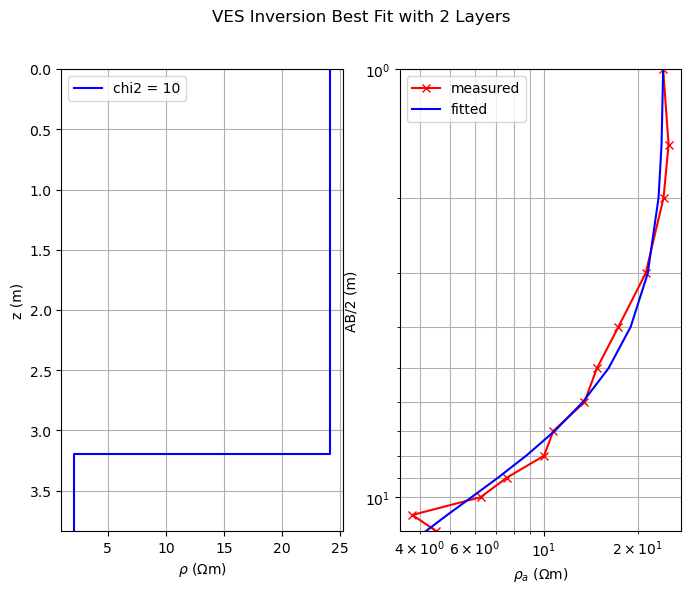

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,24.189850,0.041340,3.196798
1,2.100823,0.476004,inf


In [59]:
# Step 2: Fit mjackns data with two layers
def invert(nlay, ab2, mn2, lam, rhoa, mscheme=0.5, errPerc=3):
    print(2*max(rhoa))
   
    f = pg.core.DC1dModelling(nlay, ab2, mn2)

    transThk = pg.trans.TransLog() 
    transRho = pg.trans.TransLogLU(1, 2*max(rhoa)) 
    transRhoa = pg.trans.TransLog() 

    f.region(0).setTransModel(transThk)  
    f.region(1).setTransModel(transRho)  

    paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
    f.region(0).setStartValue(paraDepth / nlay / 2)
    f.region(1).setStartValue(np.median(rhoa))

    inv = pg.core.Inversion(rhoa, f, transRhoa, True) 
    inv.setRelativeError(errPerc / 100.0)  
    inv.setLambda(lam) 
    inv.setMarquardtScheme(mscheme)
    #help(inv)
    print("starting lambda value:", inv.getLambda(), lam)
    model = f.createStartVector()  
    #model[nlay] *= 1.5
    inv.setModel(model)
    
    model = inv.run()
    
    res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
    print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))

    fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
   
    drawModel1D(ax[0], thk, res, color='b', label=f"chi2 = {round(inv.chi2())}")
    ax[0].grid(True, which='both')
    ax[0].set_ylabel('z (m)')
    ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
    ax[0].legend(loc='best')
    #ax[0].set_ylim(max(ab2), 0)
  
    ax[1].loglog(np.array(rhoa).reshape(len(rhoa),1), np.array(ab2).reshape(len(ab2),1), 'rx-', label='measured')
    ax[1].loglog(np.array(inv.response()).reshape(len(inv.response()),1), ab2, 'b-', label='fitted')

    ax[1].set_ylim((max(ab2), min(ab2)))
    ax[1].grid(True, which='both')
    ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
    ax[1].set_ylabel('AB/2 (m)')
    ax[1].legend(loc='best')
    
    fig.suptitle(f"VES Inversion Best Fit with {nlay} Layers")
    plt.show()
    
    return model, inv.chi2(), inv.response()

df2 = mjackns

ab2 = df2["ab2"]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = df2["rhoa"]

nlay = 2

model, chi2, resp = invert(nlay, ab2, mn2, 200, rhoa, 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

In [60]:
# Get best fit data versus n
rhoaresp = resp
n = df2["n"]

In [61]:
# Set a function describing n vs. rhoa with a lead resistance

def rhoafit(n, rhoa_soil, rlead):
    a = 1
    k = np.pi*n*a*(n+1)
    
    return rhoa_soil + rlead*k

In [62]:
# Fit best fit data and cross your fingers
from scipy.optimize import curve_fit
popt, pcov = curve_fit(rhoafit, n, rhoaresp)
popt

array([21.48478729, -0.04736995])

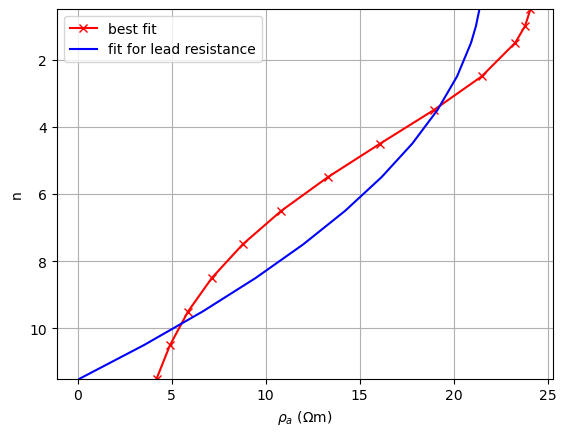

In [63]:
# Plot on top of best fit data
plt.plot(np.array(rhoaresp).reshape(len(rhoaresp),1), np.array(n).reshape(len(n),1), 'rx-', label='best fit')
plt.plot(rhoafit(n, *popt), n, 'b-', label='fit for lead resistance')
plt.ylim((max(n), min(n)))
plt.grid(True, which='both')
plt.xlabel(r'$\rho_a$ ($\Omega$m)')
plt.ylabel('n')
plt.legend(loc='best')
    

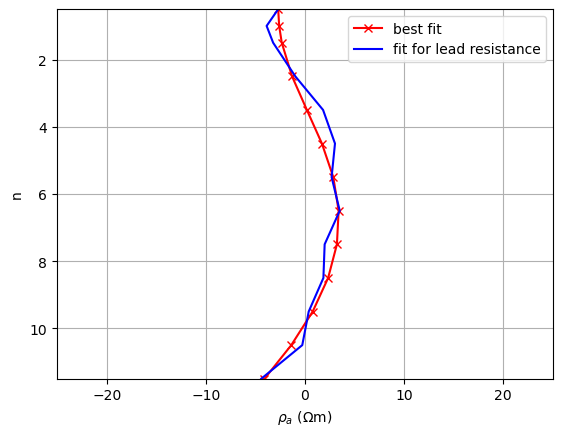

In [64]:
#...Not looking good. Subtract from current data and best fit data and plot.

# Plot on top of best fit data
plt.plot(rhoafit(n, *popt) - np.array(rhoaresp), np.array(n).reshape(len(n),1), 'rx-', label='best fit')
plt.plot(rhoafit(n, *popt) - rhoa, n, 'b-', label='fit for lead resistance')
plt.ylim((max(n), min(n)))
plt.xlim(-1*max(rhoa), max(rhoa))
plt.grid(True, which='both')
plt.xlabel(r'$\rho_a$ ($\Omega$m)')
plt.ylabel('n')
plt.legend(loc='best')

In [65]:
# Okay, not amazing. But the residuals for this fit are pretty small (±5 ohm*m).
# Function to correct rhoa based on on n and rhoa from other datasets.

def corrected_rhoa(n, rhoa, rlead):
    a = 1
    k = np.pi*n*a*(n+1)
    
    return rhoa - rlead*k

In [69]:
# Not amazing but it KINDA shows improvement? The standard deviation in rhoas after correction is:
print(np.std(corrected_rhoa(n[:-2], rhoa, popt[1])))
print(np.average(corrected_rhoa(n[:-2], rhoa, popt[1])[:-2]))

2.5496902625472213
21.07901499477599


58.6692428
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (11x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.002 s
min data = 6.26748 max data = 29.3346 (11)
min error = 0.03 max error = 0.03 (11)
min response = 21.7712 max response = 21.7712 (11)
calc without reference model
0: rms/rrms(data, response) = 7.9604/87.9517%
0: chi^2(data, response, error, log) = 294.281
0: Phi = 3237.09 + 0.693545 * 200 = 3237.09
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 0.95
1: Model: min = 0.833333; max = 32.9128
1: Response: min = 13.3609; max = 30.3659
1: rms/rrms(data, Response) = 5.89556/42.0217%
1: chi^2(data, Response, error, log) = 146.977
1: Phi = 1616.75+1.83308*200=1616.75
Iter: 1


/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


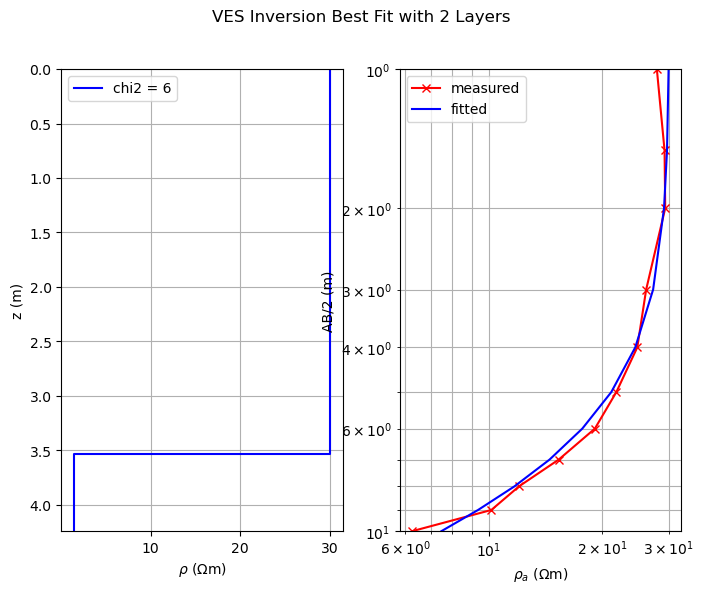

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,30.046390,0.033282,3.536237
1,1.465716,0.682260,inf


In [70]:
# Plotting djackns and its inversion
df2 = djackns

ab2 = df2["ab2"][:-2]
mn2 = np.zeros(ab2.shape) + 0.5
rhoa = df2["rhoa"][:-2]

nlay = 2

model, chi2, resp = invert(nlay, ab2, mn2, 200, rhoa, 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

In [71]:
df2

,N,a,n,ab2,r,rhoa,sigma
0,1,1,0.5,1.0,11.83,27.873781,0.035876
1,2,1,1.0,1.5,4.65,29.216812,0.034227
2,3,1,1.5,2.0,2.49,29.334621,0.034089
3,4,1,2.5,3.0,0.95,26.114489,0.038293
4,5,1,3.5,4.0,0.50,24.740042,0.040420
5,6,1,4.5,5.0,0.28,21.771237,0.045932
6,7,1,5.5,6.0,0.17,19.093029,0.052375
7,8,1,6.5,7.0,0.10,15.315264,0.065294
8,9,1,7.5,8.0,0.06,12.016592,0.083218
9,10,1,8.5,9.0,0.04,10.147344,0.098548


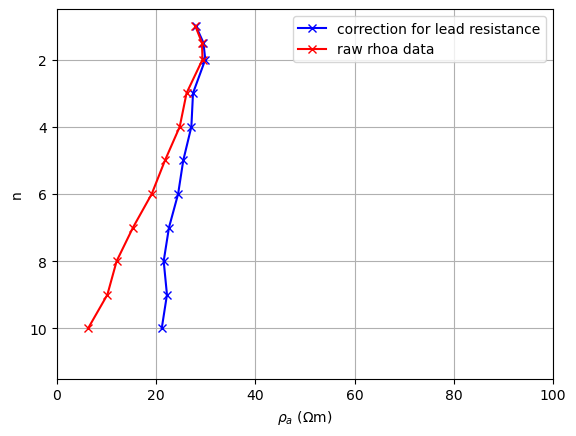

In [72]:
# Plotting corrected rhoa
plt.plot(corrected_rhoa(n[:-2], rhoa, popt[1]),ab2, 'bx-', label='correction for lead resistance')
plt.plot(rhoa, ab2, 'rx-', label='raw rhoa data')
plt.ylim((max(n), min(n)))
plt.xlim(0, 100)
plt.grid(True, which='both')
plt.xlabel(r'$\rho_a$ ($\Omega$m)')
plt.ylabel('n')
plt.legend(loc='best')

59.78537105810538
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
rrms=2.51%, chi^2=0.688
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (11x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.002 s
min data = 21.112 max data = 29.8927 (11)
min error = 0.03 max error = 0.03 (11)
min response = 25.4545 max response = 25.4545 (11)
calc without reference model
0: rms/rrms(data, response) = 3.07167/12.5819%
0: chi^2(data, response, error, log) = 16.6549
0: Phi = 183.204 + 0.2634 * 200 = 183.204
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 1
1: Model: min = 0.833333; max = 29.7406
1: Response: min = 23.3764; max = 29.0446
1: rms/rrms(data, Response) = 1.92288/7.50947%
1: chi^2(data, Response, error, log) = 6.39613
1: Phi = 70.3574+0.

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


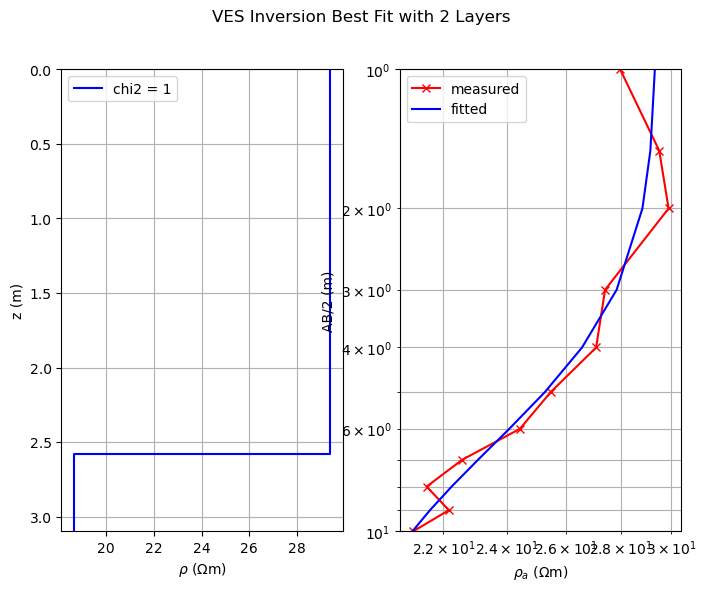

,Resistivity (Ohm*m),Conductivity (S/m),Thickness (m)
0,29.403595,0.034009,2.582316
1,18.660296,0.053590,inf


In [73]:
# Fitting corrected data with two layers
model, chi2, resp = invert(nlay, ab2, mn2, 200, corrected_rhoa(n[:-2], rhoa, popt[1]), 0.9)
res, thk = model[nlay-1:nlay*2-1], list(model[0:nlay-1])
thk.append(np.inf)
layers = pd.DataFrame({"Resistivity (Ohm*m)": res, "Conductivity (S/m)": 1/res, "Thickness (m)": thk})
layers

In [74]:
# Not amazing but it KINDA shows improvement? The standard deviation in rhoas after correction is:
print(np.std(corrected_rhoa(n[:-2], rhoa, popt[1])))
print(np.average(corrected_rhoa(n[:-2], rhoa, popt[1])))

3.0706072316310435
25.37371495359417


1409.7186488267932
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
rrms=3.84%, chi^2=1.534
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (10x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.002 s
min data = 308.116 max data = 704.859 (10)
min error = 0.03 max error = 0.03 (10)
min response = 600.772 max response = 600.772 (10)
calc without reference model
0: rms/rrms(data, response) = 127.311/35.4493%
0: chi^2(data, response, error, log) = 79.1655
0: Phi = 791.655 + 0.261784 * 200 = 791.655
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 1
1: Model: min = 0.75; max = 658.198
1: Response: min = 362.497; max = 626.84
1: rms/rrms(data, Response) = 45.3681/8.56336%
1: chi^2(data, Response, error, log) = 8.05007
1: Phi = 80.5007+1.4

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


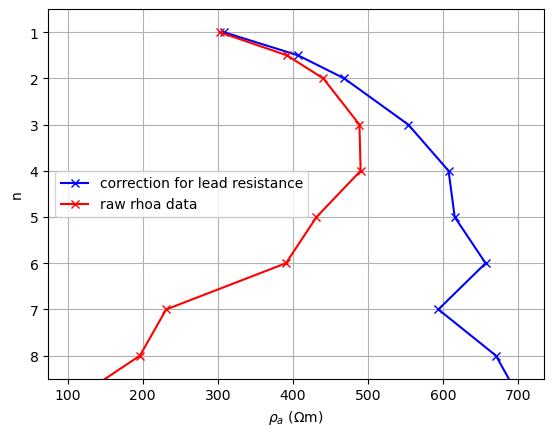

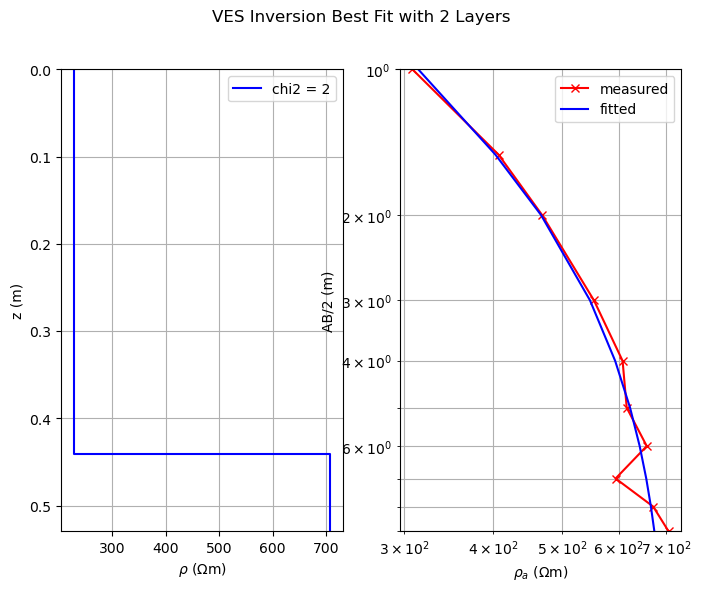

1675.0297473684975
starting lambda value: 200.0 200
rrms=9.47%, chi^2=9.146
min/max(dweight) = 33.3333/33.3333
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (10x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.001 s
min data = 350.528 max data = 837.515 (10)
min error = 0.03 max error = 0.03 (10)
min response = 613.101 max response = 613.101 (10)
calc without reference model
0: rms/rrms(data, response) = 150.836/32.0286%
0: chi^2(data, response, error, log) = 81.1711
0: Phi = 811.711 + 0.689839 * 200 = 811.711
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 1
1: Model: min = 0.75; max = 714.312
1: Response: min = 379.914; max = 677.174
1: rms/rrms(data, Response) = 80.3678/10.6887%
1: chi^2(data, Response, error, log) = 14.5436
1: Phi = 145.436+1.

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


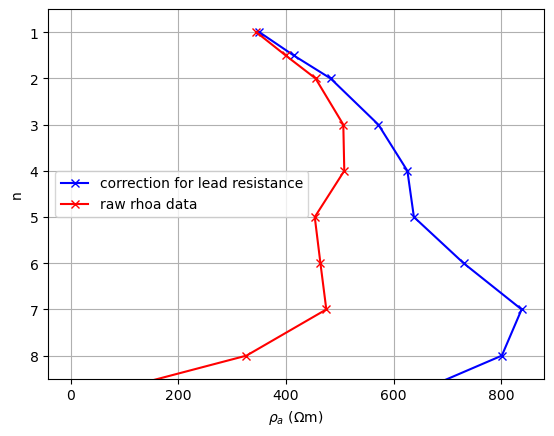

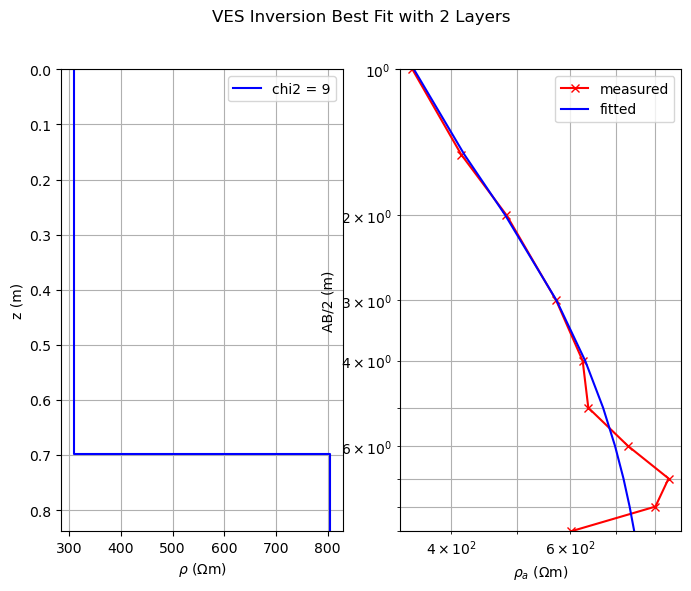

3592.0205031747755
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
rrms=13.15%, chi^2=18.458
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (11x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.003 s
min data = 893.866 max data = 1796.01 (11)
min error = 0.03 max error = 0.03 (11)
min response = 1417.71 max response = 1417.71 (11)
calc without reference model
0: rms/rrms(data, response) = 256.784/22.1237%
0: chi^2(data, response, error, log) = 42.1894
0: Phi = 464.083 + 0.40025 * 200 = 464.083
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
Linesearch tau = 1
1: Model: min = 0.833333; max = 1551.15
1: Response: min = 1137.02; max = 1522.51
1: rms/rrms(data, Response) = 215.753/15.6089%
1: chi^2(data, Response, error, log) = 26.2365
1: Phi = 288.6

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


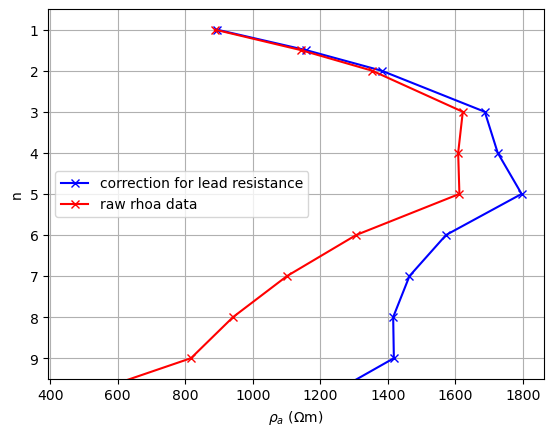

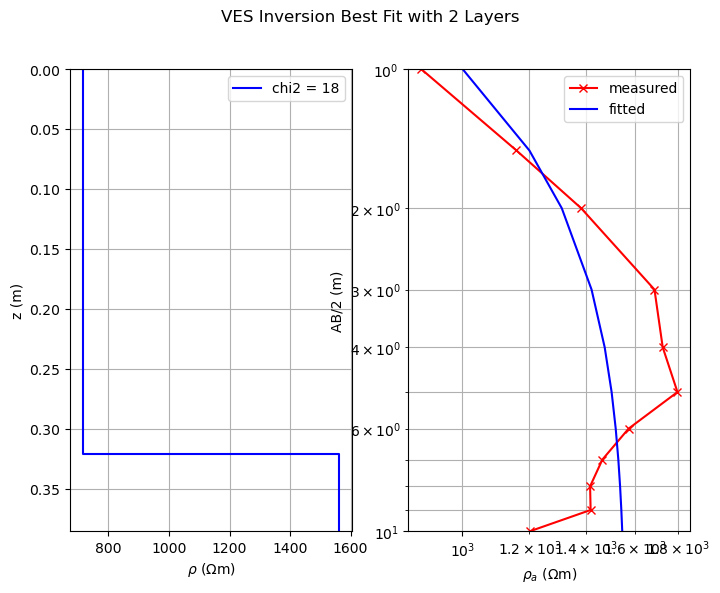

1496.9855379681562
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
rrms=37.91%, chi^2=166.870
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (11x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.002 s
min data = 33.4544 max data = 748.493 (11)
min error = 0.03 max error = 0.03 (11)
min response = 205.932 max response = 205.932 (11)
calc without reference model
0: rms/rrms(data, response) = 246.483/213.548%
0: chi^2(data, response, error, log) = 1230.33
0: Phi = 13533.7 + 6.80837 * 200 = 13533.7
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
1: LS newModel: min = 0.833333; max = 409.071
1: LS newResponse: min = 24.2596; max = 158.673
1: rms/rrms(data, LS newResponse) = 269.568/55.3339%
1: chi^2(data, LS newResponse, error, log) = 974.014
1: Phi =

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


.7
6: Response: min = 40.7893; max = 383.402
6: rms/rrms(data, Response) = 148.022/37.9118%
6: chi^2(data, Response, error, log) = 166.87
6: Phi = 1835.57+30.0829*118.098=1835.57
Reached data fit criteria (delta phi < 2%). Stop.


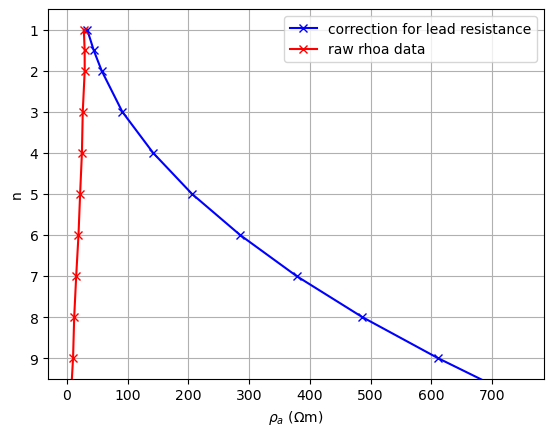

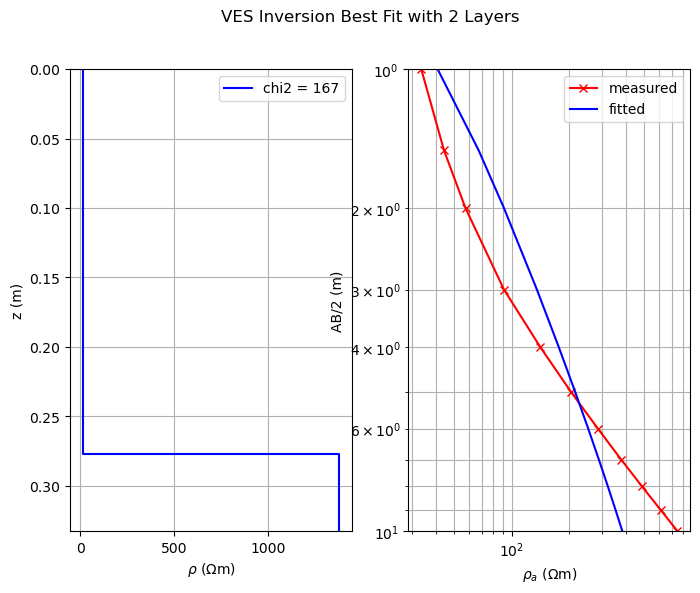

1496.9855379681562
starting lambda value: 200.0 200
min/max(dweight) = 33.3333/33.3333
use model trans from RegionManager
min/max(dweight) = 33.3333/33.3333
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (11x3)  force: 1
jacobian size invalid, forced recalc: 1
calculating jacobian matrix (forced=1)...... 0.002 s
min data = 29.6609 max data = 748.493 (11)
min error = 0.03 max error = 0.03 (11)
min response = 198.935 max response = 198.935 (11)
calc without reference model
0: rms/rrms(data, response) = 248.723/233.437%
0: chi^2(data, response, error, log) = 1329.03
0: Phi = 14619.3 + 7.10718 * 200 = 14619.3
Iter: 0
use local regularization
solve CGLSCDWWtrans with lambda = 200
1: LS newModel: min = 0.833333; max = 404.903
1: LS newResponse: min = 21.3877; max = 144.74
1: rms/rrms(data, LS newResponse) = 276.318/57.6421%
1: chi^2(data, LS newResponse, error, log) = 1120.57
1: Phi = 12326.3+21.2387*200=12326.3

/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/modellingbase.cpp:523		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


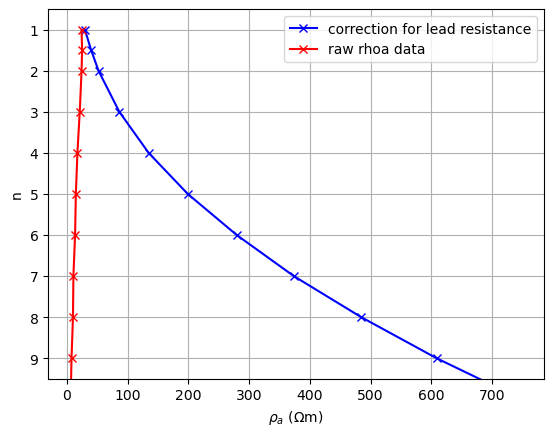

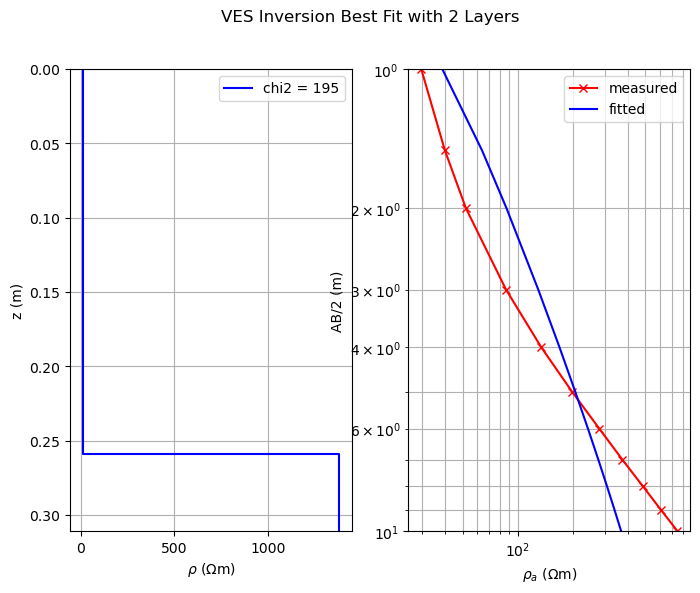

In [89]:
# Which is small enough to approximate this whole thing as one layer imo. The results for both are pretty close
# given the large margin of error.
# Okay, now trying to correct the rest of the layers with the same lead resistance.

dfs = [dcowsns, dcowses, mcowsns, djackns, mjackns]
names = ["dcowsns", "dcowses", "mcowsns", "djackns", "mjackns"]

for i in range(len(dfs)):
    df2 = dfs[i]
    
    n = df2["n"][:-2]
    ab2 = df2["ab2"][:-2]
    mn2 = np.zeros(ab2.shape) + 0.5
    rhoa = df2["rhoa"][:-2]

    nlay = 2
    
    rhoacorr = corrected_rhoa(n, rhoa, popt[1]*50)
    
    plt.plot(rhoacorr,ab2, 'bx-', label='correction for lead resistance')
    plt.plot(rhoa, ab2, 'rx-', label='raw rhoa data')
    plt.ylim((max(n), min(n)))
    plt.grid(True, which='both')
    plt.xlabel(r'$\rho_a$ ($\Omega$m)')
    plt.ylabel('n')
    plt.legend(loc='best')
    model, chi2, resp = invert(nlay, ab2, mn2, 200, rhoacorr, 0.9)

In [91]:
# So weird. Looks like this can be compensated for by a lead resistance but its different at different sites?
# This is all I have time for. I think that the lead resistance idea could explain stuff but I am likely also not understanding stuff.